In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Categorical, MultivariateNormalDiag, Dirichlet, OneHotCategorical, MultivariateNormalFullCovariance, MultivariateNormalTriL, Normal 
from functools import reduce
import time
from build_dataset import build_dataset_2dim_Kclass_gmm
from visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio
import distributions

In [3]:
distributions.covariance_2dim3(
            diag_loc=tf.constant([1.0,1.0]),
            diag_scale=tf.nn.softplus(tf.constant(0.5)),
            nondiag_loc=tf.constant(1.0),
            nondiag_scale=tf.nn.softplus(tf.constant(0.5)))

([<ed.RandomVariable 'logNormal/' shape=() dtype=float32>,
  <ed.RandomVariable 'logNormal_1/' shape=() dtype=float32>,
  <ed.RandomVariable 'Normal_2/' shape=() dtype=float32>],
 <tf.Tensor 'add_1:0' shape=(2, 2) dtype=float32>)

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


In [5]:
N = 30
K = 3
mean_true = [[-13.0,-13.0], [-11.0,16.0] , [15.0,-11.0]]
covariance_true = [[[0.8,0.2],[0.2,0.4]],
       [[1.0,-0.4],[-0.4,1.0]],
       [[0.8,0.0],[0.0,1.0]]]
mix_true  = np.array([ 1.0/3.0 , 1.0/3.0, 1.0/3.0 ])
x_data, label,mix = build_dataset_2dim_Kclass_gmm(N,K,mean_true,covariance_true,mix_true)

<IPython.core.display.Javascript object>


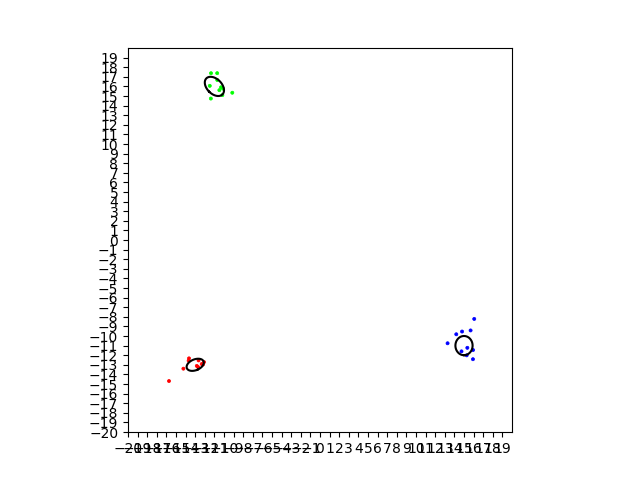

In [6]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-20.0,20.0)
ax.set_ylim(-20.0,20.0)
plt.xticks( np.arange(-20.0, 20.0, 1.0) )
plt.yticks( np.arange(-20.0, 20.0, 1.0) )
plt.gca().set_aspect('equal', adjustable='box')
plt.style.use('ggplot')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
color=["#FF0000","#00FF00","#0000FF"]
area = [[5.0]*N]
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],s=area,color=color[label[n]])
plt.show()

<IPython.core.display.Javascript object>


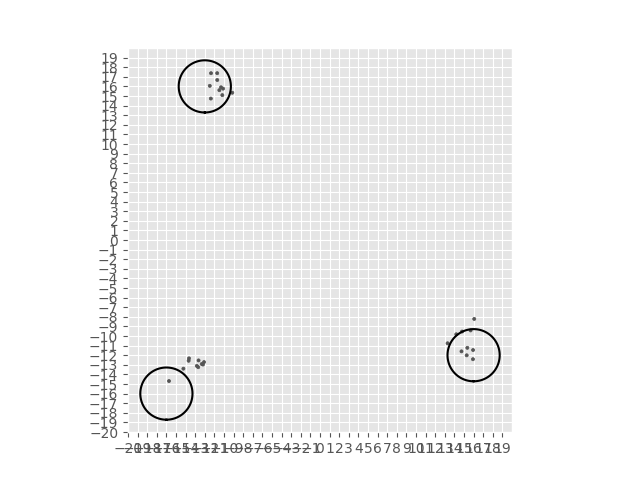

In [7]:
%matplotlib nbagg
lam_m_init = [[-16.0,-16.0],[-12.0,16.0],[16.0,-12.0]]
lam_m11_init = [1.0,1.0,1.0]
lam_m22_init = [1.0,1.0,1.0]
lam_m21_init = [0.0,0.0,0.0]
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-20.0,20.0)
ax.set_ylim(-20.0,20.0)
plt.xticks( np.arange(-20.0, 20.0, 1.0) )
plt.yticks( np.arange(-20.0, 20.0, 1.0) )
plt.gca().set_aspect('equal', adjustable='box')
plt.style.use('ggplot')
for k in range(K):
    l11=np.exp(lam_m11_init[k])
    l22=np.exp(lam_m22_init[k])
    l21=lam_m21_init[k]
    L= l11*np.array([[1.0,0.0],[0.0,0.0]])+l22*np.array([[0.0,0.0],[0.0,1.0]])+l21*np.array([[0.0,0.0],[1.0,0.0]])
    cov = np.dot(L,L.T)
    c1,c2,ca=covariance_ellipse(cov)
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+lam_m_init[k][0],ey+lam_m_init[k][1],color="black")
color=["#FF0000","#00FF00","#0000FF"]
area = [[5.0]*N]
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],s=area,color=[1.0/3.0,1.0/3.0,1.0/3.0])
plt.show()

In [10]:
def gmm_bbvi_z_pi_mu_sigma(N,K,x_data,n_iter):
    start = time.time()

    #generative model 
    alpha = tf.constant([1.0, 1.0, 1.0])
    pi = Dirichlet(concentration = alpha)
    z = [OneHotCategorical(probs = pi, dtype = tf.float32) for n in range(N)]
    mu = [MultivariateNormalFullCovariance(loc=[0.0,0.0],covariance_matrix=[[1.0,0.0],[0.0,1.0]]) for k in range(K)]
    
    #params=[[[tf.constant(1.0),tf.constant(1.0),tf.constant(1.0)],tf.nn.softplus(tf.constant(0.5))] for k in range(K)]

    sigma =[[]]*K
    Sigma =[[]]*K
    for k in range(K):
        sigma[k], Sigma[k] = distributions.covariance_2dim3(diag_loc=tf.constant([1.0,1.0]),
            diag_scale=tf.nn.softplus(tf.constant(0.5)),
            nondiag_loc=tf.constant(1.0),
            nondiag_scale=tf.nn.softplus(tf.constant(0.5)))
    
    x = [MultivariateNormalTriL(loc = sum([mu[k]*z[n][k] for k in range(K)]),
                                                    scale_tril = sum(Sigma[k]*z[n][k] for k in range(K))) for n in range(N)]
    print("generative model")
    
    #variational model
    lambda_pi = tf.nn.softplus(tf.Variable([0.0 , 0.0 , 0.0]))
    qpi = Dirichlet(concentration = lambda_pi)
    y = [tf.Variable([0.0,0.0,0.0], dtype = tf.float32) for n in range(N)]
    lambda_z = [tf.nn.softmax(y[n]) for n in range(N)]
    qz = [OneHotCategorical(probs = lambda_z[n], dtype = tf.float32) for n in range(N)]

    #lam_m_init = [[-16.0,-16.0],[-12.0,16.0],[16.0,-12.0]]
    lambda_m = [tf.Variable([-16.0,-16.0]),tf.Variable([-12.0,16.0]) ,tf.Variable([16.0,-12.0])]
    lambda_s = [tf.nn.softplus(tf.Variable(1.5)) for k in range(K)]
    qmu = [MultivariateNormalFullCovariance(loc=lambda_m[k],covariance_matrix=lambda_s[k]*[[1.0,0.0],[0.0,1.0]]) for k in range(K)]

    lambda_m11 = [tf.Variable(1.0) for k in range(K)]
    lambda_m22 = [tf.Variable(1.0) for k in range(K)] 
    lambda_m21=  [tf.Variable(0.0) for k in range(K)]
    lambda_sd = [tf.nn.softplus(tf.Variable(0.5)) for k in range(K)]
    lambda_snd = [tf.nn.softplus(tf.Variable(0.5)) for k in range(K)]
    #q_params = [[[lambda_m11[k],lambda_m22[k],lambda_m21[k]],lambda_ss[k]] for k in range(K)]
    
    qsigma = [[]]*K
    qSigma = [[]]*K
    for k in range(K):
        qsigma[k], qSigma[k] = distributions.covariance_2dim3(
            diag_loc=[lambda_m11[k],lambda_m22[k]],
            diag_scale=lambda_sd[k],
            nondiag_loc=lambda_m21[k],
            nondiag_scale=lambda_snd[k]
        )
    
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[pi]=qpi
    for k in range(K):
        latent_vars[mu[k]] =qmu[k]
        latent_vars[sigma[k][0]] =qsigma[k][0]
        latent_vars[sigma[k][1]] =qsigma[k][1]
        latent_vars[sigma[k][2]] =qsigma[k][2]

        
    x_ph =  [tf.placeholder(tf.float32,[2]) for n in range(N)]

    data = {x[n]:x_ph[n] for n in range(N)}

    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    print("inference")
    print(time.time()-start)
    sess = ed.get_session()
    tf.global_variables_initializer().run()
    loss =[]
    variational_parameter=[]
    variational_parameter.append(sess.run([lambda_pi,
                                                                           lambda_z,
                                                                           lambda_m,
                                                                           lambda_m11,
                                                                           lambda_m22,
                                                                           lambda_m21,
                                                                           lambda_sd,
                                                                           lambda_snd]))

    for t in range(inference.n_iter):
        info_dict = inference.update(feed_dict = {x_ph[n]:x_data[n] for n in range(N)})

        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_pi,
                                                                               lambda_z,
                                                                               lambda_m,
                                                                               lambda_m11,
                                                                               lambda_m22,
                                                                               lambda_m21,
                                                                               lambda_sd,
                                                                               lambda_snd]))

    print(time.time()-start)

    return loss,variational_parameter                             
                                 

In [14]:
loss,variational_parameter = gmm_bbvi_z_pi_mu_sigma(N,3,x_data,100)

generative model
variational model
inference
19.357502222061157
31.212934255599976


<IPython.core.display.Javascript object>


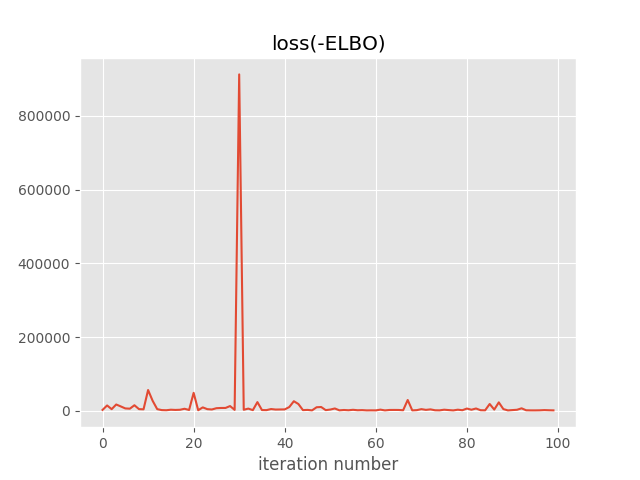

In [15]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()
#plt.savefig("20180707_loss.png")

<IPython.core.display.Javascript object>


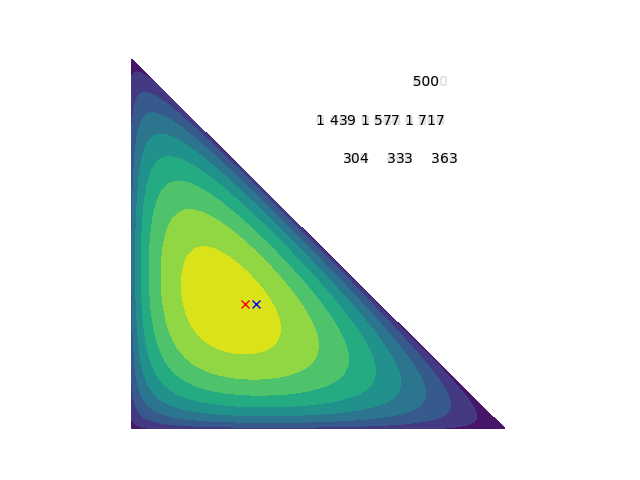

In [31]:
%matplotlib nbagg
import scipy.stats as ss
import matplotlib.tri as mtri
from matplotlib import cm
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')
X = []
Y = []

for x in np.arange(0.01,0.99,0.01):
    for y in  np.arange(0.01,0.99-x,0.01):
        X.append(x)
        Y.append(y)
triang = mtri.Triangulation(X, Y)

plt.plot(mix_true[0],mix_true[1],"bx")
artists = []
for t,vp in enumerate(variational_parameter):
    if t %100 == 0:
        dc = ss.dirichlet(np.array(vp[0]))
        
        Z = []
        for x,y in zip(X,Y):
            Z.append(dc.pdf((x,y)))

        sum_pi = vp[0][0]+vp[0][1]+vp[0][2]
        exp = vp[0]/sum_pi
            
        text = [plt.text(0.4,0.9,"iteration number : "+str(t)),
                    plt.text(0.4,0.8,"$\lambda_\pi$ : ["+"{0:.3f}".format(vp[0][0]) + " {0:.3f}".format(vp[0][1]) + " {0:.3f}]".format(vp[0][2])),
                    plt.text(0.4,0.7,"$E[\pi]$ : ["+"{0:.3f}".format(exp[0]) + " {0:.3f}".format(exp[1]) + " {0:.3f}]".format(exp[2]))]

        im_pi = ax.tricontourf(triang, Z,10)
        

        e = plt.plot(exp[0],exp[1],"rx")
        
        artists.append(im_pi.collections+text+e)
ani=animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("20180707_gmm_2dim_3class_pi.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


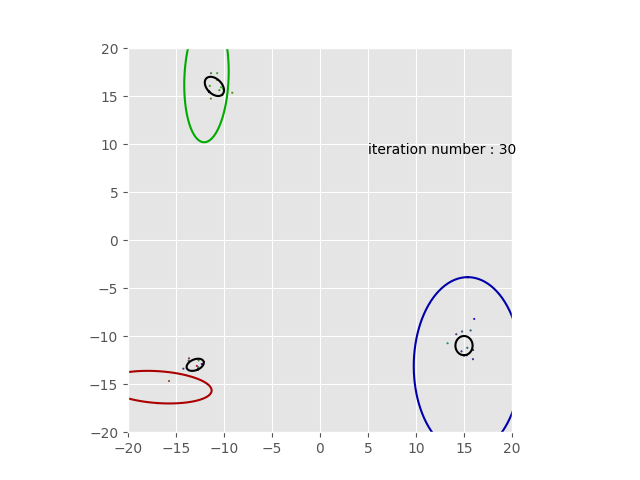

In [16]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-20.0,20.0)
ax.set_ylim(-20.0,20.0)
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
artists = []
area = [[1.0]*N]
color =["#AA0000","#00AA00","#0000AA"]
for t,vp in enumerate(variational_parameter):
    if t % 10 == 0 :
        text = [plt.text(5.0,9.0,"iteration number : "+str(t))]
        im_z=plt.scatter(x_data.T[0],x_data.T[1],s=area,color=vp[1])
        g = []
        for k in range(K):
            l11=np.exp(vp[3][k])
            l22=np.exp(vp[4][k])
            l21=vp[5][k]
            L= l11*np.array([[1.0,0.0],[0.0,0.0]])+l22*np.array([[0.0,0.0],[0.0,1.0]])+l21*np.array([[0.0,0.0],[1.0,0.0]])
            cov = np.dot(L,L.T)
            c1,c2,ca=covariance_ellipse(cov)
            ex,ey=ellipse(c1,c2,ca)
            g.append(plt.plot(ex+vp[2][k][0],ey+vp[2][k][1],color=color[k]))
        artists.append([im_z]+text+g[0]+g[1]+g[2])
        #artists.append([im_z]+text)
ani=animation.ArtistAnimation(fig,artists)

#ani.save("20180707_gmm_2dim_3class_z_mu_sigma.gif", writer='imagemagick', fps=4)